In [1]:
import numpy as np
import pandas as pd
from scipy import stats
import statsmodels.api as sm
from scipy.optimize import minimize
import matplotlib.pyplot as plt
from ipywidgets import interact, widgets

In [3]:
market_cap = pd.read_excel('Group_G copy.xlsx', sheet_name=1)
price_index = pd.read_excel('Group_G copy.xlsx', sheet_name=2, index_col='Date')
revenue = pd.read_excel('Group_G copy.xlsx', sheet_name=3)
emission = pd.read_excel('Group_G copy.xlsx', sheet_name=4)
price_index

,CAMPBELL SOUP - TOT RETURN IND (~U$) (#T) - CAMPBELL SOUP - TOT RETURN IND (~U$) (#T),ZOETIS A - TOT RETURN IND (~U$) (#T) - ZOETIS A - TOT RETURN IND (~U$) (#T),APARTMENT INV.& MAN.'A' - TOT RETURN IND (~U$) (#T) - APARTMENT INV.& MAN.'A' - TOT RETURN IND (~U$) (#T),WILLIAMS - TOT RETURN IND (~U$) (#T) - WILLIAMS - TOT RETURN IND (~U$) (#T),TNSC.'A' SBVTG. - TOT RETURN IND (~U$) (#T) - TNSC.'A' SBVTG. - TOT RETURN IND (~U$) (#T),BREAD FINANCIAL HOLDINGS - TOT RETURN IND (~U$) (#T) - BREAD FINANCIAL HOLDINGS - TOT RETURN IND (~U$) (#T),NASDAQ - TOT RETURN IND (~U$) (#T) - NASDAQ - TOT RETURN IND (~U$) (#T),ENERGEN DEAD - DELIST.30/11/18 - TOT RETURN IND (~U$) (#T) - ENERGEN DEAD - DELIST.30/11/18 - TOT RETURN IND (~U$) (#T),XEROX HOLDINGS - TOT RETURN IND (~U$) (#T) - XEROX HOLDINGS - TOT RETURN IND (~U$) (#T),UNIVERSAL HEALTH SVS.'B' - TOT RETURN IND (~U$) (#T) - UNIVERSAL HEALTH SVS.'B' - TOT RETURN IND (~U$) (#T),...,WSP GLOBAL - TOT RETURN IND (~U$) (#T) - WSP GLOBAL - TOT RETURN IND (~U$) (#T),CHIMERA INVESTMENT - TOT RETURN IND (~U$) (#T) - CHIMERA INVESTMENT - TOT RETURN IND (~U$) (#T),SYNOVUS FINANCIAL - TOT RETURN IND (~U$) (#T) - SYNOVUS FINANCIAL - TOT RETURN IND (~U$) (#T),FORTIS - TOT RETURN IND (~U$) (#T) - FORTIS - TOT RETURN IND (~U$) (#T),FREEHOLD ROYALTIES - TOT RETURN IND (~U$) (#T) - FREEHOLD ROYALTIES - TOT RETURN IND (~U$) (#T),CHEESECAKE FACTORY - TOT RETURN IND (~U$) (#T) - CHEESECAKE FACTORY - TOT RETURN IND (~U$) (#T),ROYAL CARIBBEAN GROUP - TOT RETURN IND (~U$) (#T) - ROYAL CARIBBEAN GROUP - TOT RETURN IND (~U$) (#T),ENTERPRISE PRDS.PTNS.LP. - TOT RETURN IND (~U$) (#T) - ENTERPRISE PRDS.PTNS.LP. - TOT RETURN IND (~U$) (#T),BIRCHCLIFF ENERGY - TOT RETURN IND (~U$) (#T) - BIRCHCLIFF ENERGY - TOT RETURN IND (~U$) (#T),SUPERIOR PLUS - TOT RETURN IND (~U$) (#T) - SUPERIOR PLUS - TOT RETURN IND (~U$) (#T)
Date,,,,,,,,,,,,,,,,,,,,,
1999-01-01,6625.85,NaN,276.80,1874.56,153.56,NaN,NaN,4410.36,678.75,1024.69,...,NaN,NaN,4878.04,254.19,33.86,244.84,441.26,70.31,NaN,94.26
1999-01-04,6497.85,NaN,280.98,1814.45,158.25,NaN,NaN,4396.23,677.31,1041.98,...,NaN,NaN,4865.33,252.98,34.41,234.27,420.40,76.22,NaN,95.57
1999-01-05,6671.03,NaN,280.52,1795.67,154.96,NaN,NaN,4396.23,690.25,1046.91,...,NaN,NaN,4966.96,256.35,34.73,233.23,436.82,79.17,NaN,95.83
1999-01-06,6607.78,NaN,281.91,1852.02,154.55,NaN,NaN,4382.09,703.55,1045.68,...,NaN,NaN,5068.58,260.95,35.38,231.17,459.20,83.31,NaN,97.19
1999-01-07,6517.05,NaN,275.40,1852.02,153.77,NaN,NaN,4283.14,700.32,1016.05,...,NaN,NaN,4827.22,266.59,36.87,222.40,448.78,82.72,NaN,97.02
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-26,13531.69,503.29,2299.70,6271.60,768.72,364.26,1471.70,NaN,106.71,12286.12,...,2179.03,54.08,4374.88,4149.85,1465.38,1066.24,858.25,2220.63,1840.54,662.87
2022-12-27,13595.48,501.70,2236.86,6288.54,773.71,360.55,1464.50,NaN,107.37,12329.76,...,2193.17,54.96,4404.78,4176.78,1474.89,1052.60,842.91,2233.61,1852.48,667.17
2022-12-28,13474.99,496.62,2202.31,6158.66,764.53,347.95,1457.77,NaN,104.95,12164.79,...,2164.19,51.24,4379.66,4112.86,1424.19,1048.94,827.40,2203.01,1757.99,663.93


In [4]:
def assets_returns(assets, period, compounded=True):
    if not compounded:
        asset_return = (assets / assets.shift(periods=period)) - 1
    elif compounded:
        diff = assets / assets.shift(periods=period)
        asset_return = np.log(diff.astype('float'))
    return asset_return

In [5]:
simple_return = assets_returns(price_index.loc[:, price_index.columns != 'Date'], period=1, compounded=False)

In [6]:
log_return = assets_returns(price_index.loc[:, price_index.columns != 'Date'], period=1, compounded=True)

/Users/victoriawong/opt/anaconda3/lib/python3.9/site-packages/pandas/core/internals/blocks.py:402: RuntimeWarning: divide by zero encountered in log
  result = func(self.values, **kwargs)


In [7]:
def get_moment(assetReturn, moment):
    if moment == 1:
        return pd.DataFrame(assetReturn.mean())
    elif moment == 2:
        return pd.DataFrame(assetReturn.std())
    elif moment == 3:
        return pd.DataFrame(assetReturn.skew())
    elif moment == 4:
        nu = (pow(assetReturn, moment)).mean() - pow(assetReturn.mean(), moment)
        den = pow(assetReturn.std(), moment)
        res = nu / den
        return pd.DataFrame(res)

In [8]:
simple_mean = get_moment(simple_return, 1)
simple_std = get_moment(simple_return, 2)
simple_skew = get_moment(simple_return, 3)
simple_kurt = get_moment(simple_return, 4)

In [9]:
def jarque_bera(series, skewness, kurtosis):
    t = np.shape(series)[0]
    tstat = t * (pow(skewness, 2)/6 + pow((kurtosis), 2)/24)
    return tstat

In [10]:
jb_res = jarque_bera(simple_return, simple_skew, simple_kurt)

In [11]:
def jb_test(tstat, alpha, dof):
    critical_val = stats.chi2.ppf(1-alpha, df=dof)
    out = {}
    for k, v in tstat.T.items():
        if v[0] >= critical_val:

            # print(f'Reject H0: Return is not Gaussian')
            out[k] = 'Reject H0: Return is not Gaussian'
    return pd.Series(out)

In [12]:
test_res = jb_test(jb_res, 0.05, 2)

In [13]:
def get_acf(ds: pd.DataFrame, nlags=10) -> pd.DataFrame:
    out = {}
    for k in ds.keys():
        res = sm.tsa.acf(ds[k], nlags=nlags, missing='conservative')
        out[k] = res[1:]
    return pd.DataFrame(out)

In [14]:
acf = get_acf(simple_return, nlags=10)
squared_acf = get_acf(pow(simple_return, 2), nlags=10)

/Users/victoriawong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/stattools.py:463: RuntimeWarning: invalid value encountered in double_scalars
  xo = x - x.sum() / notmask_int.sum()
/Users/victoriawong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/stattools.py:518: RuntimeWarning: invalid value encountered in true_divide
  acov = np.fft.ifft(Frf * np.conjugate(Frf))[:nobs] / d[nobs - 1 :]
/Users/victoriawong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/stattools.py:463: RuntimeWarning: invalid value encountered in subtract
  xo = x - x.sum() / notmask_int.sum()


In [15]:
def ljung_box(acf, returns, nlag):
    t = np.shape(returns)[0]
    tstat = t*(t+2)*1/(t-nlag)*pow(acf.iloc[nlag],2)
    return tstat


lj_stat = {}
for i in range(10):
    lj_stat[i] = ljung_box(acf, simple_return, i)
lj_stat = pd.DataFrame(lj_stat).transpose()

In [16]:
# Filtered portfolio inputs
opt_simple = simple_return.dropna(thresh=145).dropna(axis=1)
opt_mean = get_moment(opt_simple, 1)
opt_vol = get_moment(opt_simple, 2)
opt_skew = get_moment(opt_simple, 3)
opt_kurt = get_moment(opt_simple, 4)


# For annualized portfolio inputs
annual_mean = pow((1+opt_mean), 252) -1
annual_vol = opt_vol * np.sqrt(252)

In [17]:
def get_weight(num_assets, size):
    weights = np.random.randn(num_assets, size)
    weights = pd.DataFrame(weights)
    for i in range(size):
        weights.iloc[:, i] = weights.iloc[:, i] / weights.iloc[:, i].sum()
    return weights


# On the rows are each asset's weight in different portfolios, each column represents a randomly generated portfolio
random_weight = get_weight(np.shape(opt_simple)[1], 1000 )

In [18]:
def portfolio_return(asset_returns, port_weight):
    if np.shape(asset_returns)[1] != np.shape(port_weight)[0]:
        port_mean = asset_returns.T.values @ port_weight.values
    else:
        port_mean = asset_returns.values @ port_weight.values
    port_mean = pd.DataFrame(port_mean).transpose()
    port_mean.index = port_weight.T.index
    port_mean.columns = ['Portfolio Mean']
    return port_mean


def vcv_matrix(asset_returns):
    return asset_returns.cov()


def portfolio_var(port_weight, vcv):
    out = {}
    for i in port_weight:
        out[i] = port_weight.iloc[:, i].values.T @ vcv.values @ port_weight.iloc[:, i].values
    out = pd.Series(out)
    out.name = 'Sigma'
    return out

In [19]:
opt_mu = portfolio_return(opt_mean, random_weight)
opt_vcv = vcv_matrix(opt_simple)
opt_sigma2 = portfolio_var(random_weight, opt_vcv)
opt_sigma = np.sqrt(opt_sigma2)
annual_opt_mu = pow((1+opt_mu), 252) -1
annual_opt_vol = opt_sigma * np.sqrt(252)

In [20]:
def efficient_frontier(mean, vcv, risk_aversion, num_port):
    """

    :param mean: All asset's expected return
    :param vcv: The variance covariance matrix
    :param risk_aversion: Investor's risk aversion
    :param num_port: Number of equally spaced return portfolios we want display on the efficient frontier
    
    :return: This function returns a list of objects.
        frontier: The mean variance efficient frontier with x number of MVP portfolios
        gmvp_weight: The asset allocation of the global minimum variance portfolio
        gmvp_mean: The mean of the global minimum variance portfolio
        gmvp_variance: The variance of the global minimum variance portfolio
        optimal_weight: The asset allocation of the optimal portfolio
        optimal_mean: The mean of the optimal portfolio
        optimal_variance: The variance of the optimal portfolio
    """

    e = np.ones(np.shape(mean)[0])
    vcv_inv = np.linalg.inv(vcv)
    A = mean.T @ vcv_inv @ mean
    B = mean.T @ vcv_inv @ e
    C = e.T @ vcv_inv @ e
    alpha_spec = (e.T @ vcv_inv @ mean) / risk_aversion
    alpha_min = 1-alpha_spec

    # The mean-variance efficient frontier
    mu = np.linspace(-0.1, 0.25, num_port)
    std = ((C * pow(mu, 2) - 2*B*mu + A)/(A*C-pow(B, 2))).T.reshape(-1)
    frontier = pd.DataFrame({'mu_p': mu, 'mu_std': std})

    # The global mean variance portfolio
    gmvp_weight = vcv_inv @ e / C
    gmvp_mean = gmvp_weight.T @ mean
    gmvp_variance = gmvp_weight.T @ vcv @ gmvp_weight

    # The speculative portfolio
    spec_weight = vcv_inv @ mean / (e.T @ vcv_inv @ mean)
    spec_mean = spec_weight.T @ mean
    spec_variance = spec_weight.T @ vcv @ spec_weight

    # The optimal portfolio
    optimal_weight = alpha_min * gmvp_weight.reshape(-1) + alpha_spec * spec_weight.reshape(-1)
    optimal_mean = optimal_weight.T @ mean
    optimal_variance = optimal_weight.T @ vcv @ optimal_weight

    return [frontier, gmvp_weight, gmvp_mean, gmvp_variance, optimal_weight, optimal_mean, optimal_variance]

In [21]:
r = efficient_frontier(opt_mean.values, opt_vcv.values, risk_aversion=2, num_port=100)
r[0]

,mu_p,mu_std
0,-0.100000,0.040812
1,-0.096465,0.037990
2,-0.092929,0.035269
3,-0.089394,0.032649
4,-0.085859,0.030130
...,...,...
95,0.235859,0.224355
96,0.239394,0.231142
97,0.242929,0.238031
98,0.246465,0.245021


In [22]:
@interact()
def plot(risk_aversion=widgets.FloatSlider(min=0, max=10, step=0.1, value=1)):

    f = efficient_frontier(opt_mean.values, opt_vcv, risk_aversion=risk_aversion, num_port=100)

    ax = plt.gca()
    ax.plot(f[0]['mu_std'], f[0]['mu_p'])
    gmvp_weight = f[1]
    gmvp_retr = f[2]
    gmvp_vcv = f[3]

    optimal_variance = f[-1]
    optimal_mu = f[-2]

    ax.plot(gmvp_vcv, gmvp_retr, 'ro')
    ax.plot(optimal_variance, optimal_mu, 'bo')
    
#     d = np.linspace(0, 0.25, 101)
#     ax.plot(d, y, 'k--')
    ax.axhline(y=0,color='k', ls='-')

interactive(children=(FloatSlider(value=1.0, description='risk_aversion', max=10.0), Output()), _dom_classes=(…

In [23]:
# Efficient frontier using optimization method
def min_variance_portfolio(mean, vcv, initial_weight):
    """

    :param vcv: The variance covariance matrix
    :param initial_weight: Initial guess of asset weight allocation
    :param risk_free:
    
    :return: Returns a list of objects.
    1. Optimal weight allocation of assets given the covariance matrix
    2. The return of this global minimum variance portfolio
    3. The variance of this global minimum variance portfolio
    """
    obj = lambda a: a.T @ vcv @ a
    cons = {
        'type': 'eq',
        'fun': lambda a: a.T @ (np.zeros(len(a)) + 1) - 1
    }
    bnds = [[None, None] for i in range(len(initial_weight))]
    port_weight = minimize(obj, x0=initial_weight, constraints=cons, bounds=bnds)
    r = port_weight.x.reshape(1, -1)
    port_mean = r @ mean
    port_vcv = r @ vcv @ r.T
    return [port_weight, port_mean, port_vcv]

In [24]:
pweight = min_variance_portfolio(opt_mean, opt_vcv, r[1])
gmvp_weight = pweight[0]
gmvp_mean = pweight[1]
gmvp_variance = pweight[2]
gmvp_mean

,0
0,0.000407


In [25]:
def optimal_portfolio(mean, vcv, initial_weight, risk_free):
    vcv_inv = np.linalg.inv(vcv)
    ones = np.ones((np.shape(mean)[0], 1))
    
    obj = lambda a: a.T @ vcv @ a
    cons = {
        'type': 'eq',
        'fun' : lambda a: a.T @ mean + (1 - ones.T @ a) * risk_free - a.T @ mean
    }
    bnds = [(None, None) for i in range(len(initial_weight))]
    port_weight = minimize(obj, x0=initial_weight, method='SLSQP', constraints=cons, bounds=bnds)
    a_str = port_weight.x.reshape(-1, 1)
#     optimal_portfolio = port_weight.x.reshape(1, -1)
#     port_mean = optimal_portfolio @ mean
    
    excess_mu = mean - risk_free * ones
#     tan_port = (vcv_inv @ excess_mu) / (ones.T @ vcv_inv @ excess_mu)
    tan_port = a_str / (ones.T @ a_str)
    tan_mu = tan_port.T @ excess_mu + risk_free
    tan_vcv = tan_port.T @ vcv @ tan_port
#     return [port_weight.x, optimal_portfolio, port_mean, tan_port, tan_mu, tan_vcv]
    
    return tan_port, tan_mu, tan_vcv


# res = optimal_portfolio(opt_mean.values, opt_vcv, minport, 0.005)
# res[-2]


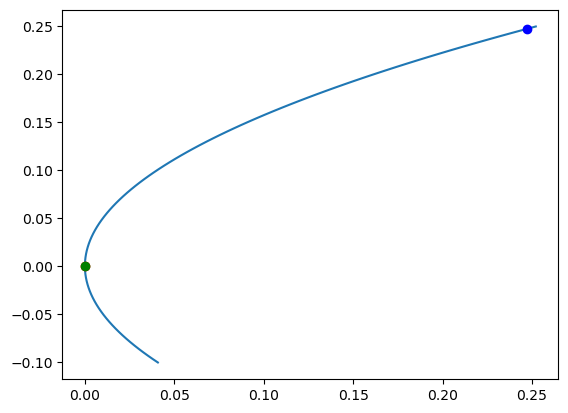

In [26]:
f = efficient_frontier(opt_mean.values, opt_vcv.values, risk_aversion=1, num_port=100)

ax = plt.gca()
ax.plot(f[0]['mu_std'], f[0]['mu_p'])
gmvp_weight = f[1]
gmvp_retr = f[2]
gmvp_vcv = f[3]

optimal_variance = f[-1]
optimal_mu = f[-2]

ax.plot(gmvp_vcv, gmvp_retr, 'ro')
ax.plot(optimal_variance, optimal_mu, 'bo')

res = optimal_portfolio(opt_mean.values, opt_vcv.values, r[1], 0.05)
ax.plot(res[-1], res[-2], 'go')
    
#     d = np.linspace(0, 0.25, 101)
#     ax.plot(d, y, 'k--')
# ax.axhline(y=0,color='g', ls='-')

In [27]:
gmvp_vcv

1.4515524956689552e-05

In [57]:
# ax = plt.gca()
# y2 = list(f[0]['mu_std']) # this is actually the squared root of the variance


# pmus = []
# pvols = []
# for i in range(len(random_weight.columns)):
#     res = ef_optimization(opt_vcv, random_weight.iloc[:, i], risk_free=False)

#     pmu = res.x @ opt_mean
#     pvol = res.x.T @ opt_vcv @ res.x
#     pmus.append(pmu)
#     pvols.append(pvol)
#     ax.plot(np.sqrt(pvol).T, pmu, 'ro')

# # ax.set_ylim(-0.01, 0.02)
# # ax.set_xlim(0, 0.05)
# ax.plot(y2, f['mu_p'])
# f['mu_std']

In [58]:
# ax = plt.gca()
# ax.plot(pvols, pmus, 'ro')
# ax.plot(y2, f['mu_p'])
# ax.set_xlim(0, 0.01)
# ax.set_ylim(-0.05, 0.05)

In [32]:
def portfolio_resampling(row_selected, num_iter, risk_aversion, len_dummy_mu):
    """

    :param row_selected: Number of draws of raw returns we have for each sample
    :param num_iter: Number of resampled returns
    :param len_dummy_mu: Number of portfolio returns we set to optimize for portfolio volatility
    :return: The output contains multiple outputs. First, the optimal allocation given all returns, the expected return of the portfolio, the variacne of the optimal portfolios.
    """
    out = []
    optimal_weights = []
    optimal_mu = []
    optimal_vcv = []
    for i in range(num_iter):
        sam = opt_simple.sample(n=row_selected, ignore_index=True)
        mu = sam.mean()
        optimal_mu.append(mu)
        cov = sam.cov()
        optimal_vcv.append(cov)
        res = efficient_frontier(mu, cov, risk_aversion, len_dummy_mu)
        print(res[0])
        num = np.linalg.inv(cov) @ np.ones(np.shape(cov)[0])
        den = np.ones(np.shape(cov)[0]).T @ np.linalg.inv(cov) @ np.ones(np.shape(cov)[0])
        alpha = num / den
        out.append(res[0]['mu_std'])
        optimal_weights.append(alpha)
    df = pd.DataFrame(np.asarray(out).T, index=resp[0]['mu_p'])
    optimal_weights = pd.DataFrame(optimal_weights).T
    optimal_mu = pd.DataFrame(optimal_mu)
    return [df, optimal_weights, optimal_mu]

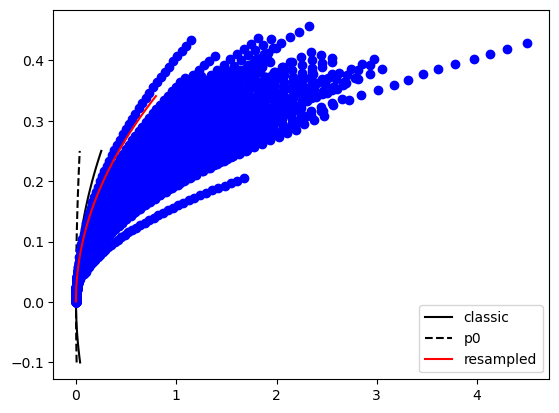

In [33]:
Q = 100
m = 51
returns = opt_simple
nb_rows = 200
risk_aversion = 2
num_port = 101

ax = plt.gca()

p0 = returns.sample(n=nb_rows, ignore_index=True)
ft, _, min_mu, min_cov, _, max_mu, max_cov = efficient_frontier(returns.mean(), returns.cov(), risk_aversion, num_port)
ax.plot(ft.mu_std, ft.mu_p, 'k-', label='classic')


ft, _, min_mu, min_cov, _, max_mu, max_cov = efficient_frontier(p0.mean(), p0.cov(), risk_aversion, num_port)
ax.plot(ft.mu_std, ft.mu_p, 'k--', label='p0')

mu_0 = p0.mean()
cov_0 = p0.cov()

opt_mus = []
opt_covs = []
a_res = [[] for i in range(m)]
for i in range(Q):
    p1 = np.random.normal(loc=p0.mean().values, scale=p0.std().values, size=p0.shape)
    mu_1 = p1.mean(axis=0).reshape(-1, 1)
    cov_1 = np.cov(p1.T)
    c = 0
    for mu in np.linspace(min_mu, max_mu, m):
        obj = lambda a: a.T @ cov_1 @ a
        cons1 = {
            'type': 'eq',
            'fun': lambda a: a.T @ (np.zeros(len(a)) + 1) - 1
        }
        cons2 = {
            'type': 'eq',
            'fun': lambda a: a.T @ mu_1 - mu
        }
        w0 = np.random.random(mu_1.shape)
        w0 /= w0.sum()
        bnds = [[None, None] for i in range(len(w0))]
        res = minimize(obj, x0=w0.reshape(-1), method='SLSQP', constraints=(cons1, cons2), bounds=bnds)
        r = res.x
        opt_mu = r.T @ mu_0
        opt_cov = r.T @ cov_0 @ r
        ax.plot(opt_cov, opt_mu, 'bo')
        opt_mus.append(opt_mu)
        opt_covs.append(opt_cov)
        a_res[c].append(r)
        c += 1
        
mu_res = []
cov_res = []
ares = []
for i in range(m):
    _a_res = np.asarray(a_res)[i].sum(axis=0)/Q
    mu_res.append(_a_res.T @ mu_0)
    cov_res.append(_a_res.T @ cov_0 @ _a_res)
    ares.append(_a_res)

ax.plot(cov_res, mu_res, 'r-', label='resampled', ms=3)
ax.legend()

In [ ]:
def save_results(mu_res, cov_res, ares, filename):
    index_name = ...s
    mu_res = pd.DataFrame(mu_res, index=index_name)
    cov_res = pd.DataFrame(cov_res, index=index_name)
    ares = pd.DataFrame(ares, index=index_name)
    
    mu_res.to_csv(f'{filename}_mu.csv')
    cov_res.to_csv(f'{filename}_cov.csv')
    ares_res.to_csv(f'{filename}_ares.csv')

(-0.1, 0.5)

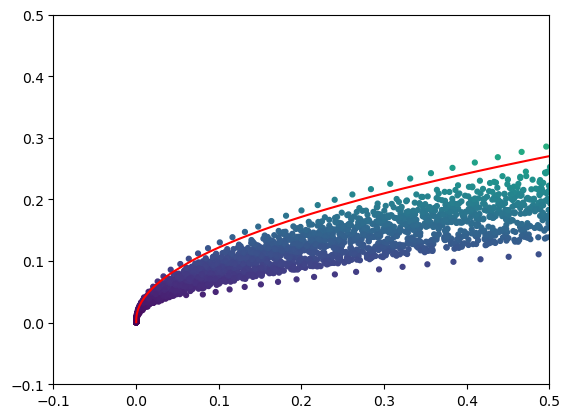

In [34]:
ax = plt.gca()

ax.plot(cov_res, mu_res, 'r-')
ax.scatter(opt_covs, opt_mus, c=np.asarray(opt_mus), s=12)
ax.set_xlim(-0.1, 0.5)
ax.set_ylim(-0.1, 0.5)

In [ ]:
# In sample MVP portfolios 

In [36]:
resampled_mu = pd.read_csv('mu_res.csv')
resampled_vcv = pd.read_csv('vcv_res')

In [37]:
#Average Annualized MVP Return
Expectation_MVP = resampled_mu.iloc[0]
Expectation_MVP = Expectation_MVP.drop(Expectation_MVP.index[0])
Expectation_MVP = Expectation_MVP.to_numpy()
A_Expectation_MVP = Expectation_MVP*252
A_Expectation_MVP

array([0.08458431])

In [ ]:
#Annualized volatility of the MVP
Variance_MVP = resampled_vcv.iloc[0]
Std_MVP = np.sqrt(Variance_MVP)
A_Std_MVP = Std_MVP * np.sqrt(252)
A_Std_MVP

In [ ]:
#MVP Weights
Weights_MVP = resampled_weight.iloc[0]
Weights_MVP = Weights_MVP.drop(Weights_MVP.index[0])
Weights_MVP = Weights_MVP.to_numpy()

#Minimum daily return of the MVP
Returns_daily_MVP = np.matmul(opt_simple,Weights_MVP)
Min_Returns_Daily_MVP = np.min(Returns_daily_MVP)
Min_Returns_Daily_MVP

In [ ]:
#Maximum daily return of the MVP
Returns_daily_MVP = np.matmul(opt_simple,Weights_MVP)
Min_Returns_Daily_MVP = np.max(Returns_daily_MVP)
Min_Returns_Daily_MVP

In [ ]:
#MVP performance
portfolio_values_MVP = [100]
for ret in Returns_daily_MVP:
    portfolio_values_MVP.append(portfolio_values_MVP[-1]*(1+ret))

plt.plot(portfolio_values_MVP)
plt.legend(['MVP Performance'])
plt.show()

In [ ]:
#Maximum Drawdown MVP
pd_portfolio_values_MVP = pd.Series(portfolio_values_MVP)
max_data_stock = pd_portfolio_values_MVP.rolling(window=len(pd_portfolio_values_MVP), min_periods=1).max()
dd_stock = pd_portfolio_values_MVP/max_data_stock - 1
MDD_stock = dd_stock.rolling(window=len(pd_portfolio_values_MVP), min_periods=1).min()
MDD_stock.min()

In [ ]:
#VaR and ES at 5% of the MVP
quantile_threshold = 0.05

quantile = np.quantile(Returns_daily_MVP, quantile_threshold)

expected_shortfall = np.mean(Returns_daily_MVP[Returns_daily_MVP<=quantile])

plt.hist(Returns_daily_MVP, 60)
VaR_95_MVP = np.percentile(Returns_daily_MVP, 5)
plt.axvline(x=VaR_95_MVP, color='r', linestyle='dashed', linewidth=2)
plt.axvline(x=expected_shortfall, color='g', linestyle='dashed', linewidth=2)
plt.legend(['VaR 5%','ES 5%'])
plt.show()

In [ ]:
print("Value at Risk 5%:", VaR_95_MVP)
print("Expected Shortfall: ", expected_shortfall)

In [ ]:
# Equally weighted portfolio

In [ ]:
#Average Annualized MVP Return
Weights_EWP = [1/len(opt_mean)]*len(opt_mean)
Weights_EWP = np.array(Weights_EWP)
Weights_EWP_T = np.transpose(Weights_EWP)
Return_EWP = np.matmul(Weights_EWP_T,opt_mean)
A_Return_EWP = Return_EWP*252
A_Return_EWP

In [ ]:
#Annualized volatility of the EWP
Variance_EWP = np.matmul(Weights_EWP_T,np.matmul(opt_vcv,Weights_EWP))
Std_EWP = np.sqrt(Variance_EWP)
A_Std_EWP = Std_EWP * np.sqrt(252)
A_Std_EWP

In [ ]:
#Minimum daily return of the EWP
Returns_daily_EWP = np.matmul(opt_simple,Weights_EWP)
Min_Returns_Daily_EWP = np.min(Returns_daily_EWP)
Min_Returns_Daily_EWP

In [ ]:
#Maximum daily return of the MVP
Max_Returns_Daily_EWP = np.max(Returns_daily_EWP)
Max_Returns_Daily_EWP

In [ ]:
#EWP Performance
portfolio_values_EWP = [100]
for ret in Returns_daily_EWP:
    portfolio_values_EWP.append(portfolio_values_EWP[-1]*(1+ret))

plt.plot(portfolio_values_EWP)
plt.legend(['EWP Performance'])
plt.show()

In [ ]:
#Maximum Drawdown EWP
pd_portfolio_values_EWP = pd.Series(portfolio_values_EWP)
max_data_stock = pd_portfolio_values_EWP.rolling(window=len(pd_portfolio_values_EWP), min_periods=1).max()
dd_stock = pd_portfolio_values_EWP/max_data_stock - 1
MDD_stock = dd_stock.rolling(window=len(pd_portfolio_values_EWP), min_periods=1).min()
MDD_stock.min()

In [ ]:
#VaR and ES at 5% of the EWP
quantile_threshold = 0.05

quantile = np.quantile(Returns_daily_EWP, quantile_threshold)

expected_shortfall = np.mean(Returns_daily_EWP[Returns_daily_EWP<=quantile])

plt.hist(Returns_daily_EWP, 60)
VaR_95_EWP = np.percentile(Returns_daily_EWP, 5)
plt.axvline(x=VaR_95_EWP, color='r', linestyle='dashed', linewidth=2)
plt.axvline(x=expected_shortfall, color='g', linestyle='dashed', linewidth=2)
plt.legend(['VaR 5%','ES 5%'])
plt.show()

In [ ]:
print("Value at Risk 5%:", VaR_95_EWP)
print("Expected Shortfall: ", expected_shortfall)

In [ ]:
# Value weighted portfolio 

In [ ]:
#Average Annualized VWP Return
market_cap['day'] = market_cap['Date'].dt.day
last_day_of_month = market_cap[market_cap['day'] == market_cap.groupby(market_cap['Date'].dt.month)['day'].transform('max')]
last_day_of_month = last_day_of_month.drop(columns=['Date', '#ERROR', '#ERROR.1', 'DENBURY - MARKET VALUE', 'EXCO RES - MARKET VALUE', 'day'])
opt_market = last_day_of_month.dropna(thresh=145).dropna(axis=1)
sum_list = opt_market.sum(axis=0)
Weights_VWP = [v / sum(sum_list) for v in sum_list]
Weights_VWP_T = np.transpose(Weights_VWP)
Return_VWP = np.matmul(Weights_VWP_T,opt_mean)
A_Return_VWP = Return_VWP*252
A_Return_VWP

In [ ]:
#Annualized volatility of the VWP
Variance_VWP = np.matmul(Weights_VWP_T,np.matmul(opt_vcv,Weights_VWP))
Std_VWP = np.sqrt(Variance_VWP)
A_Std_VWP = Std_VWP * np.sqrt(252)
A_Std_VWP

In [ ]:
#Minimum daily return of the VWP
Returns_daily_VWP = np.matmul(opt_simple,Weights_VWP)
Min_Returns_Daily_VWP = np.min(Returns_daily_VWP)
Min_Returns_Daily_VWP

In [ ]:
#Maximum daily return of the VWP
Returns_daily_VWP = np.matmul(opt_simple,Weights_VWP)
Max_Returns_Daily_VWP = np.max(Returns_daily_VWP)
Max_Returns_Daily_VWP

In [ ]:
#VWP Performance
portfolio_values_VWP = [100]
for ret in Returns_daily_VWP:
    portfolio_values_VWP.append(portfolio_values_VWP[-1]*(1+ret))

plt.plot(portfolio_values_VWP)
plt.legend(['VWP Performance'])
plt.show()

In [ ]:
#Maximum Drawdown VWP
pd_portfolio_values_VWP = pd.Series(portfolio_values_VWP)
max_data_stock = pd_portfolio_values_VWP.rolling(window=len(pd_portfolio_values_VWP), min_periods=1).max()
dd_stock = pd_portfolio_values_VWP/max_data_stock - 1
MDD_stock = dd_stock.rolling(window=len(pd_portfolio_values_VWP), min_periods=1).min()
MDD_stock.min()

In [ ]:
#VaR and ES at 5% of the VWP
quantile_threshold = 0.05

quantile = np.quantile(Returns_daily_VWP, quantile_threshold)

expected_shortfall = np.mean(Returns_daily_VWP[Returns_daily_VWP<=quantile])

plt.hist(Returns_daily_VWP, 60)
VaR_95_VWP = np.percentile(Returns_daily_VWP, 5)
plt.axvline(x=VaR_95_EWP, color='r', linestyle='dashed', linewidth=2)
plt.axvline(x=expected_shortfall, color='g', linestyle='dashed', linewidth=2)
plt.legend(['VaR 5%','ES 5%'])
plt.show()

In [ ]:
print("Value at Risk 5%:", VaR_95_VWP)
print("Expected Shortfall: ", expected_shortfall)

In [ ]:
#Graph of the performance of the 3 portfolios

fig = plt.figure()
ax = fig.add_subplot(111)

ax.plot(portfolio_values_MVP, label='MVP')
ax.plot(portfolio_values_EWP, label='EWP')
ax.plot(portfolio_values_VWP, label='VWP')

ax.set_title('Portfolio Values')
ax.legend()

plt.show()